In [7]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_nex_vor = pd.read_csv('data/TB_nex_vor.csv', parse_dates=['Date'])

In [4]:
# remove spaces from column names in NEX data
for c in df_nex_vor.columns:
    if ' ' in c:
        df_nex_vor.rename(columns={c: re.sub(' ', '_', c)}, inplace=True)

In [5]:
df_vor = df_nex_vor

<AxesSubplot:ylabel='Frequency'>

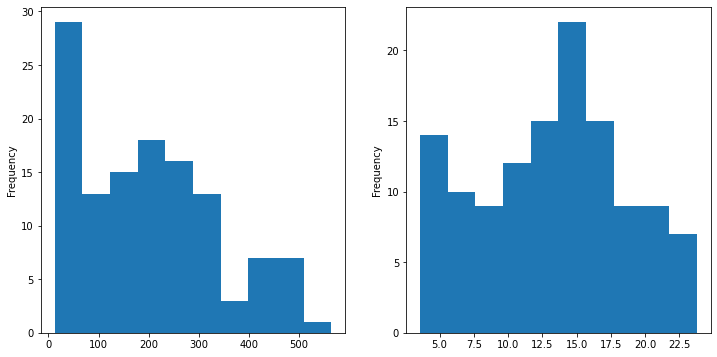

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
df_vor['Total_Weight_(g/m^2)'].plot.hist(ax=ax[0])
df_vor['Total_Weight_(g/m^2)'].transform(lambda x: np.power(x, 0.5)).plot.hist(ax=ax[1])

In [15]:
mod_both = smf.ols("Q('Total_Weight_(g/m^2)') ~ High_cm + Low_cm", data=df_vor).fit()

In [16]:
mod_both.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Q('Total_Weight_(g/m^2)')   R-squared:                       0.530
Model:                                   OLS   Adj. R-squared:                  0.522
Method:                        Least Squares   F-statistic:                     66.96
Date:                       Tue, 18 Jan 2022   Prob (F-statistic):           3.29e-20
Time:                               09:59:34   Log-Likelihood:                -728.70
No. Observations:                        122   AIC:                             1463.
Df Residuals:                            119   BIC:                             1472.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8012     27.111     -0.103      0.918     -56.483      50.881
High_cm        2.2159      1.285      1.724      0.087      -0.329       4.760
Low_cm        11.9372      2.318      5.151      0.000       7.348      16.526
==============================================================================
Omnibus:                        2.019   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.364   Jarque-Bera (JB):                1.597
Skew:                           0.268   Prob(JB):                        0.450
Kurtosis:                       3.164   Cond. No.                         115.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

eval_env: 1
eval_env: 1
eval_env: 1


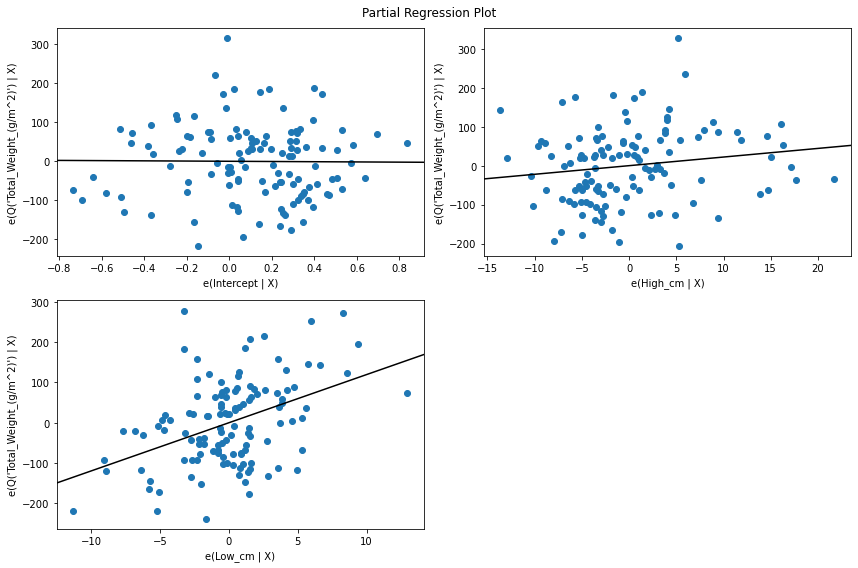

In [17]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_partregress_grid(mod_both, fig=fig)
fig.tight_layout(pad=1.0)

### other data
* there is VOR+clipping data from weight gain project, not ready yet (2019 might be ready, not sure about VOR, Elle is weighing 2020 data) - will prioritize 2019/2020 VOR
    * this will be the best VOR/Clipping data
    * 2019 - much of the VOR data won't be usable (but clipping is ok!). Lauren needs to figure out when date cut-off is for fix.
* Courtenay's bird habitat project has a ton of VOR data (30 m transects, since 2015) - can talk with David about this.
    * Clipping done a month later about 8 m away at subset of locations(60-80 locs)
* some other projects from 2014/2015 that Lauren can access
    * This would be nice to expand spatial coverage and burns
* USFS project in 2015/2016 - grid sampliing
    * not sure of their protocol (observations may be too limited)
    * data might be hard to access (a lot of people no longer there)